# Setup

In [1]:
import random

import torch
from torchvision.transforms import Resize

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Utils.utils import *
from Utils.dataset import *
from Utils.model_loading import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("whitegrid")
sns.set_palette("husl")

d:\Anaconda3\envs\machine_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda:0


# Benchmarks
Evaluate all models and store their stats (accuracy, latency, ...) in a json file. Then load the stats from that json to use for comparisons.

Note: Some benchmarks need to be updated. Some of the plotting functions were refactored and have not been updated here.

## Benchmark All Models

- TODO: Test inference difference between TensorRT w/wo PyTorch loaded.

In [2]:
json_path = "model_stats.json"

# Main models
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 128,
    transform  = Resize((152, 152), antialias=None)
)

models = {
    "alexnet":            "AlexNet",
    "vgg16_bn":           "VGG16",
    "vgg16_bn_custom":    "VGG16 Custom 152",
    "resnet18":           "ResNet18", 
    "mobilenet_v3":       "MobileNetV3 Large", 
    "mobilenet_v3_small": "MobileNetV3 Small", 
    "ofa_595M":           "OFA 595M", 
    "ofa_pixel1_20":      "OFA Pixel 1 20ms",
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    stat = benchmark_model(loaded_model, dataloader["test"], name)
    add_model_stat_to_json(json_path, stat)
    del loaded_model

# MobileNetV3 Small resolution analysis models
resolutions = [80, 104, 128, 152, 176, 200, 224]
for r in resolutions:
    dataloader = build_dataloader(
        train_path = "Data/mitbih_mif_train_small.h5",
        test_path  = "Data/mitbih_mif_test.h5",
        batch_size = 128,
        transform  = Resize((r, r), antialias=None)
    )
    model = load_model_from_pretrained("mobilenet_v3_small", f"Pretrained/MobileNetV3-Small/mobilenet_v3_small_ecg_ep15_i{r}.pth", 5)
    stat = benchmark_model(model, dataloader["test"], f"MobileNetV3 Small - Resolution {r}")
    add_model_stat_to_json(json_path, stat)
    del model

# Pruning
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 32,
    transform  = Resize((152, 152), antialias=None)
)

pruning_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
for pr in pruning_ratios:
    p_model = load_vgg_from_pruned(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_p{pr}.pth", pr, torch.rand((1, 3, 152, 152)))
    p_stat = benchmark_model(p_model, dataloader["test"], f"VGG16 - Layer Pruned {pr}")
    add_model_stat_to_json(json_path, p_stat)
    del p_model

    g_model = torch.load(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_g{pr}.pth")
    g_stat = benchmark_model(g_model, dataloader["test"], f"VGG16 - Global Pruned {pr}")
    add_model_stat_to_json(json_path, g_stat)
    del g_model

# Pruned VGG custom
p_model = load_vgg_custom_from_pruned(f"Pretrained/VGG-Pruned/vgg16_bn_custom_ecg_ep30_i152_p0.8.pth", 0.8, torch.rand((1, 3, 152, 152)))
p_stat = benchmark_model(p_model, dataloader["test"], f"VGG16 Custom 152 - Layer Pruned 0.8")
add_model_stat_to_json(json_path, p_stat)
del p_model

[INFO]: Benchmarking model AlexNet
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for AlexNet finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model ResNet18
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for ResNet18 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Large
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Large finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model OFA 595M
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for OFA 595M finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model OFA Pixel 1 20ms
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for OFA Pixel 1 20ms finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 80
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 80 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 104
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 104 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 128
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 128 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 152
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 152 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 176
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 176 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 200
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 200 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 224
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 224 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.5
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.5 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.5
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.5 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.6
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.6 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.6
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.6 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.7
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.7 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.7
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.7 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.8
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.8 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.8
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.8 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.9
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.9 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.9
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.9 finished
[INFO]: Adding model stat to model_stats.json


In [2]:
# Quantized models ran through TensorRT engine
from Quantization.benchmark_trt import benchmark_model_trt

json_path = "model_stats.json"

dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 1,
    transform  = Resize((152, 152), antialias=None)
)

models = {
    "resnet18": [
        ("ResNet18 - TRT FP32", "fp32"),
        ("ResNet18 - TRT FP16", "fp16"),
    ],
    "mobilenet_v3_small": [
        ("MobileNetV3 Small - TRT FP32", "fp32"),
        ("MobileNetV3 Small - TRT FP16", "fp16"),
    ]
}

for model, precisions in models.items():
    for name, precision in precisions:
        engine_path = f"Quantization/Engine/{model}_ecg_ep50_i152_{precision}.engine"
        stat = benchmark_model_trt(engine_path, dataloader["test"], name)
        add_model_stat_to_json(json_path, stat)

[I]: Benchmarking TensorRT model ResNet18 - TRT FP32 from Quantization/Engine/resnet18_ecg_ep50_i152_fp32.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for ResNet18 - TRT FP32 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking TensorRT model ResNet18 - TRT FP16 from Quantization/Engine/resnet18_ecg_ep50_i152_fp16.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for ResNet18 - TRT FP16 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking TensorRT model MobileNetV3 Small - TRT FP32 from Quantization/Engine/mobilenet_v3_small_ecg_ep50_i152_fp32.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for MobileNetV3 Small - TRT FP32 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking TensorRT model MobileNetV3 Small - TRT FP16 from Quantization/Engine/mobilenet_v3_small_ecg_ep50_i152_fp16.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for MobileNetV3 Small - TRT FP16 finished
[I]: Adding model stat to model_stats.json


In [ ]:
# Pruned VGG

from Quantization.benchmark_trt import benchmark_model_trt
json_path = "model_stats.json"

dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 1,
    transform  = Resize((152, 152), antialias=None)
)

engine_path = f"Quantization/Engine/vgg16_bn_custom_ecg_ep30_i152_p0.8_fp16.engine"
stat = benchmark_model_trt(engine_path, dataloader["test"], "VGG16 Custom 152 - Layer Pruned 0.8 - TRT FP16")
add_model_stat_to_json(json_path, stat)

engine_path = f"Quantization/Engine/vgg16_bn_custom_ecg_ep30_i152_p0.8_int8.engine"
stat = benchmark_model_trt(engine_path, dataloader["test"], "VGG16 Custom 152 - Layer Pruned 0.8 - TRT INT8")
add_model_stat_to_json(json_path, stat)

In [2]:
# Half precision models without TensorRT

json_path = "model_stats.json"

dataloader = build_dataloader(
    train_path     = "Data/mitbih_mif_train_small.h5",
    test_path      = "Data/mitbih_mif_test.h5",
    batch_size     = 128,
    transform      = Resize((152, 152), antialias=None),
    half_precision = True
)

models = {
    "resnet18":           "ResNet18 - FP16", 
    "mobilenet_v3_small": "MobileNetV3 Small - FP16", 
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    stat = benchmark_model(loaded_model.to(torch.float16), dataloader["test"], name, no_latency=True)
    add_model_stat_to_json(json_path, stat)
    del loaded_model

[I]: Benchmarking model ResNet18 - FP16
[I]: 	Getting model params and MACs
[I]: 	Latency measurement skipped
[I]: 	Evaluating


[I]: Benchmarking for ResNet18 - FP16 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking model MobileNetV3 Small - FP16
[I]: 	Getting model params and MACs
[I]: 	Latency measurement skipped
[I]: 	Evaluating


[I]: Benchmarking for MobileNetV3 Small - FP16 finished
[I]: Adding model stat to model_stats.json


In [4]:
# GPU latency without TensorRT
json_path = "model_stats.json"


# Half precision. For now, manually replace the latency in the json file
models = {
    "resnet18":           "ResNet18 - FP16", 
    "mobilenet_v3_small": "MobileNetV3 Small - FP16", 
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    model_stat   = get_model_stats_from_json(json_path, [name])[0]

    dummy_input  = torch.rand((1, 3, 152, 152)).to(torch.float16)

    latencies = []
    for _ in range(0, 10):
        latencies.append(measure_latency(loaded_model.to(torch.float16), dummy_input, test_device=device))
    model_stat.latency = sum(latencies) / len(latencies)
    print(model_stat)

    del loaded_model


# Full precision
models = {
    "resnet18":           "ResNet18", 
    "mobilenet_v3_small": "MobileNetV3 Small", 
    "vgg16_bn_custom":    "VGG16 Custom 152"
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    model_stat   = get_model_stats_from_json(json_path, [name])[0]

    dummy_input  = torch.rand((1, 3, 152, 152))

    latencies = []
    for _ in range(0, 10):
        latencies.append(measure_latency(loaded_model, dummy_input, test_device=device))
    model_stat.latency = sum(latencies) / len(latencies)

    model_stat.name = f"{name} - FP32"
    add_model_stat_to_json(json_path, model_stat)

    del loaded_model

# Pruned VGG custom
models = {
    "vgg16_bn_custom": "VGG16 Custom 152 - Layer Pruned 0.8"
}

for model, name in models.items():
    loaded_model = load_vgg_custom_from_pruned(f"Pretrained/VGG-Pruned/{model}_ecg_ep30_i152_p0.8.pth", 0.8, torch.rand((1, 3, 152, 152)), 5)
    model_stat   = get_model_stats_from_json(json_path, [name])[0]

    dummy_input  = torch.rand((1, 3, 152, 152))

    latencies = []
    for _ in range(0, 10):
        latencies.append(measure_latency(loaded_model, dummy_input, test_device=device))
    model_stat.latency = sum(latencies) / len(latencies)

    model_stat.name = f"{name} - FP32"
    add_model_stat_to_json(json_path, model_stat)

    del loaded_model

ModelStats(name='ResNet18 - FP16', macs=880630784.0, params=11179077, latency=0.0034244098901748655, accuracy=98.38754272460938)
ModelStats(name='MobileNetV3 Small - FP16', macs=30815864.0, params=1522981, latency=0.007043296384811401, accuracy=97.92617797851562)
[I]: Adding model stat to model_stats.json
[I]: Adding model stat to model_stats.json


In [14]:
# Full precision VGG 224
json_path = "model_stats.json"

dataloader = build_dataloader(
    train_path     = "Data/mitbih_mif_train_small.h5",
    test_path      = "Data/mitbih_mif_test.h5",
    batch_size     = 32,
    transform      = Resize((224, 224), antialias=None),
)

# Benchmark
loaded_model = load_model_from_pretrained("vgg16_bn", f"Pretrained/vgg16_bn_ecg_ep50_i224.pth", 5)
model_stat   = benchmark_model(loaded_model, dataloader["test"], "VGG16 - Resolution 224")
add_model_stat_to_json(json_path, model_stat)

# GPU Latency
model_stat  = get_model_stats_from_json(json_path, ["VGG16 - Resolution 224"])[0]
dummy_input = torch.rand((1, 3, 224, 224))

latencies = []
for _ in range(0, 10):
    latencies.append(measure_latency(loaded_model, dummy_input, test_device=device))
model_stat.latency = sum(latencies) / len(latencies)

model_stat.name = f"VGG16 - Resolution 224 - FP32"
add_model_stat_to_json(json_path, model_stat)

del loaded_model

[I]: Benchmarking model VGG16 - Resolution 224
[I]: 	Getting model params and MACs
[I]: 	Measuring latency
[I]: 	Evaluating


[I]: Benchmarking for VGG16 - Resolution 224 finished
[I]: Adding model stat to model_stats.json
[I]: Adding model stat to model_stats.json


## Size of Training Data

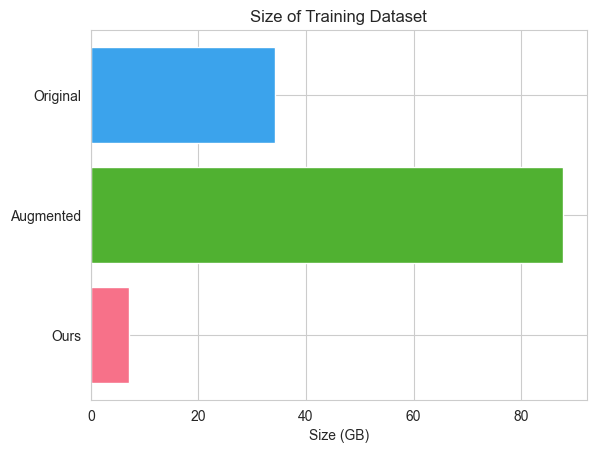

In [10]:
# Size of training data

original_data = get_dataset_size(image_size=187, channels=3, num_images=87554, data_width=32)
paper_data    = get_dataset_size(image_size=227, channels=3, num_images=152471, data_width=32)
my_data       = get_dataset_size(image_size=152, channels=3, num_images=27554, data_width=32)

compare_single_values(
    [original_data, paper_data, my_data],
    ["Original", "Augmented", "Ours"],
    axis  = "Size (GB)",
    title = "Size of Training Dataset",
)

## Model Comparison

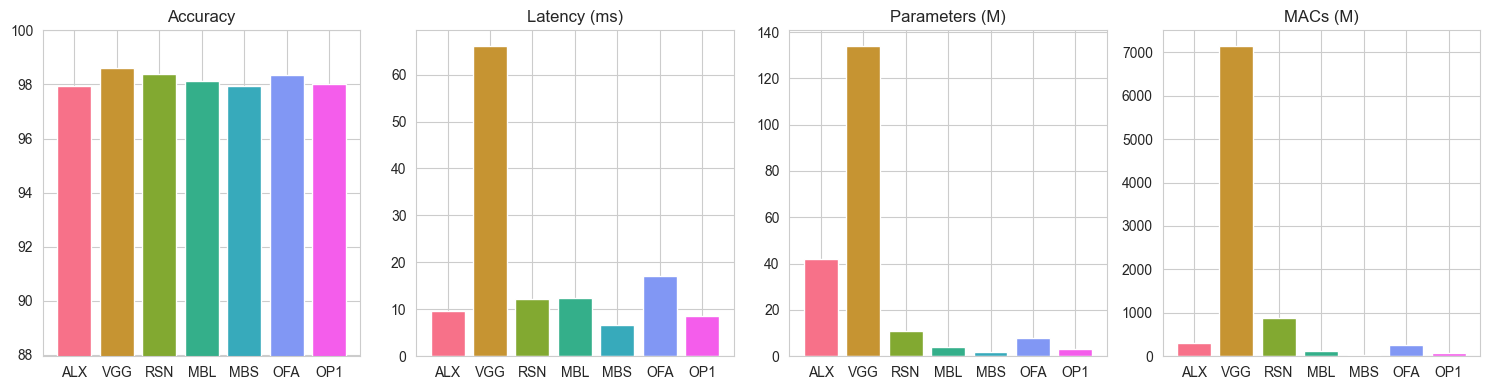

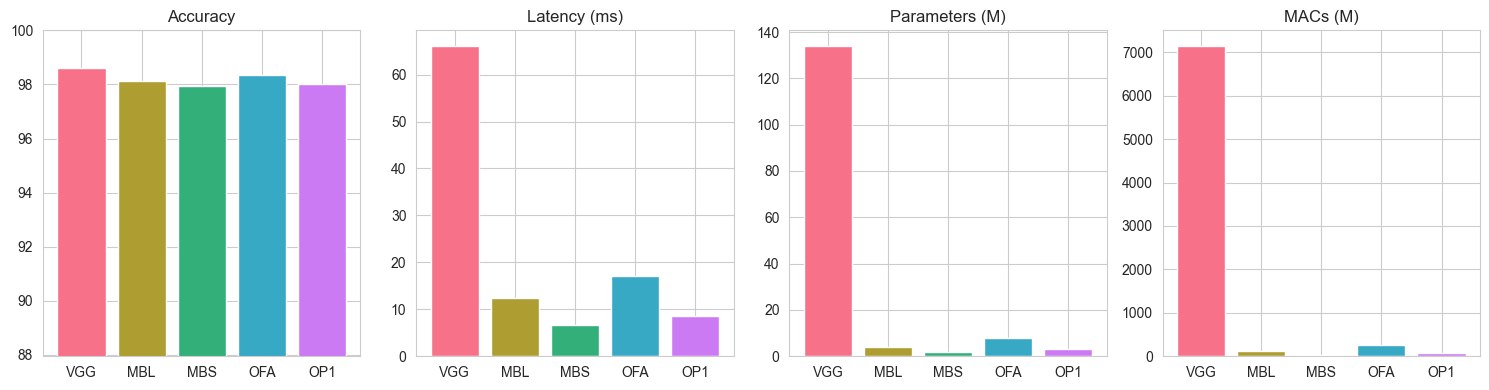

In [5]:
models = {
    "AlexNet":           "ALX",
    "ResNet18":          "RSN",
    "VGG16":             "VGG", 
    "MobileNetV3 Large": "MBL", 
    "MobileNetV3 Small": "MBS", 
    "OFA 595M":          "OFA", 
    "OFA Pixel 1 20ms":  "OP1"
}

stats = get_model_stats_from_json("model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, fig_size=(15, 4))
compare_models([stats[1], stats[3], stats[4], stats[5], stats[6]], fig_size=(15, 4))

## Resolution Analysis

### Best Accuracy and Latency

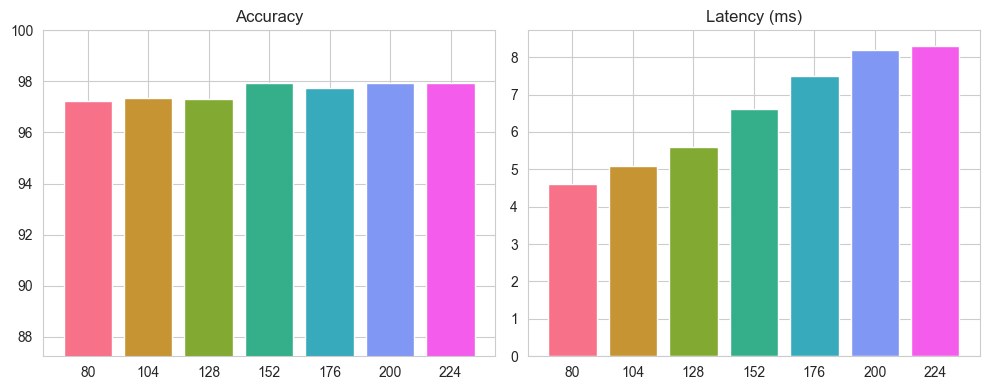

In [7]:
models = {
    "MobileNetV3 Small - Resolution 80":  "80",
    "MobileNetV3 Small - Resolution 104": "104",
    "MobileNetV3 Small - Resolution 128": "128", 
    "MobileNetV3 Small - Resolution 152": "152", 
    "MobileNetV3 Small - Resolution 176": "176", 
    "MobileNetV3 Small - Resolution 200": "200", 
    "MobileNetV3 Small - Resolution 224": "224"
}

stats = get_model_stats_from_json("model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, show_macs=False, show_params=False)

### Running Accuracy and Loss

- Running data can be collected by training the model and recording the loss-per-batch and accuracy-per-epoch.

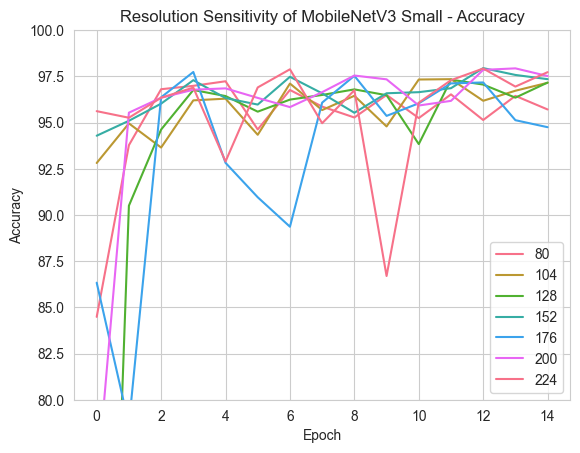

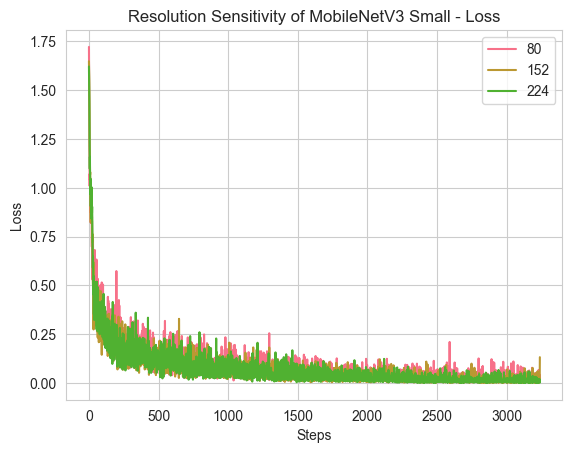

In [8]:
running_accuracy_raw = np.loadtxt("running_acc_2.txt")
running_loss_raw     = np.loadtxt("running_loss_2.txt")
running_accuracy     = dict()
running_loss         = dict()
for i, accs in enumerate(running_accuracy_raw):
    running_accuracy[str(resolutions[i])] = accs

running_loss[80]  = running_loss_raw[0]
running_loss[152] = running_loss_raw[3]
running_loss[224] = running_loss_raw[6]

compare_list_values(
    running_accuracy,
    y_axis  = "Accuracy",
    x_axis  = "Epoch",
    title   = "Resolution Sensitivity of MobileNetV3 Small - Accuracy",
    y_range = (80, 100),
)
compare_list_values(
    running_loss,
    y_axis = "Loss",
    x_axis = "Steps",
    title  = "Resolution Sensitivity of MobileNetV3 Small - Loss",
)

## VGG Pruning

### Per-layer Sparsity

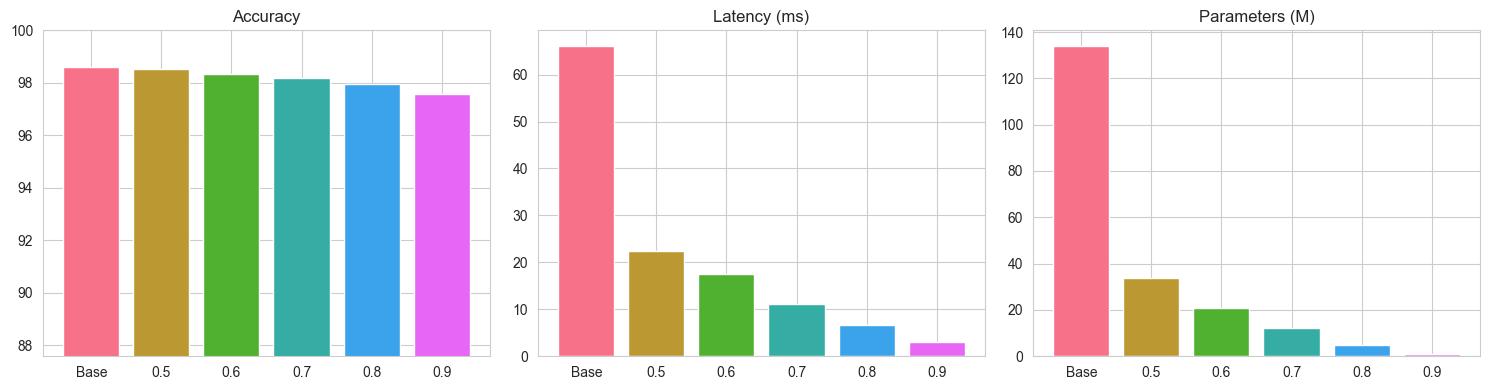

In [9]:
models = {
    "VGG16":                     "Base",
    "VGG16 - Layer Pruned 0.5":  "0.5",
    "VGG16 - Layer Pruned 0.6":  "0.6",
    "VGG16 - Layer Pruned 0.7":  "0.7",
    "VGG16 - Layer Pruned 0.8":  "0.8",
    "VGG16 - Layer Pruned 0.9":  "0.9",
}

stats = get_model_stats_from_json("model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, show_macs=False, fig_size=(15, 4))

### Global Sparsity

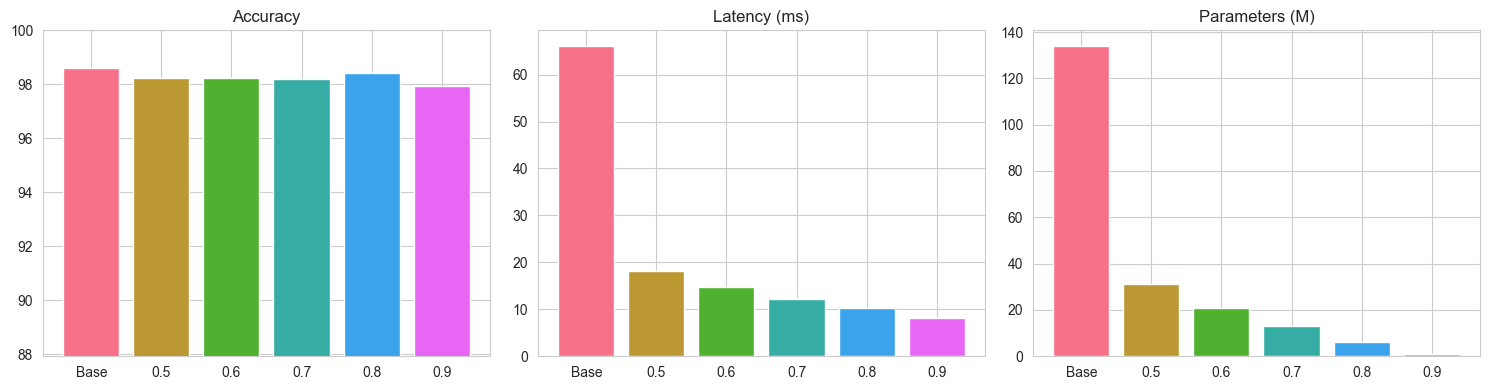

In [10]:
models = {
    "VGG16":                      "Base",
    "VGG16 - Global Pruned 0.5":  "0.5",
    "VGG16 - Global Pruned 0.6":  "0.6",
    "VGG16 - Global Pruned 0.7":  "0.7",
    "VGG16 - Global Pruned 0.8":  "0.8",
    "VGG16 - Global Pruned 0.9":  "0.9",
}

stats = get_model_stats_from_json("model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, show_macs=False, fig_size=(15, 4))

### Per-layer vs Global

In [14]:
def plot_layer_vs_global(stats):
    names   = ["0.5", "0.6", "0.7", "0.8", "0.9"]
    accs    = [(stats[i].accuracy, stats[i+1].accuracy) for i in range(0, len(stats), 2)]
    latency = [(stats[i].latency, stats[i+1].latency) for i in range(0, len(stats), 2)]

    colors = sns.color_palette("husl", 2)

    _, ax = plt.subplots(1, 2, figsize=(15, 4))
    current_bar = 0
    for group in accs:
        ax[0].bar(current_bar, group[0], color=colors[0])
        current_bar += 1

        ax[0].bar(current_bar, group[1], color=colors[1])
        current_bar += 2

    current_bar = 0
    for group in latency:
        ax[1].bar(current_bar, round(group[0] * 1000, 1), color=colors[0])
        current_bar += 1

        ax[1].bar(current_bar, round(group[1] * 1000, 1), color=colors[1])
        current_bar += 2

    ax[0].set_ylim([97, 100])
    ax[0].set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax[0].set_xticklabels(names)
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Sparsity")
    ax[0].legend(["Layer", "Global"])

    ax[1].set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax[1].set_xticklabels(names)
    ax[1].set_title("Latency (ms)")
    ax[1].set_xlabel("Sparsity")
    ax[1].legend(["Layer", "Global"])

    plt.show()

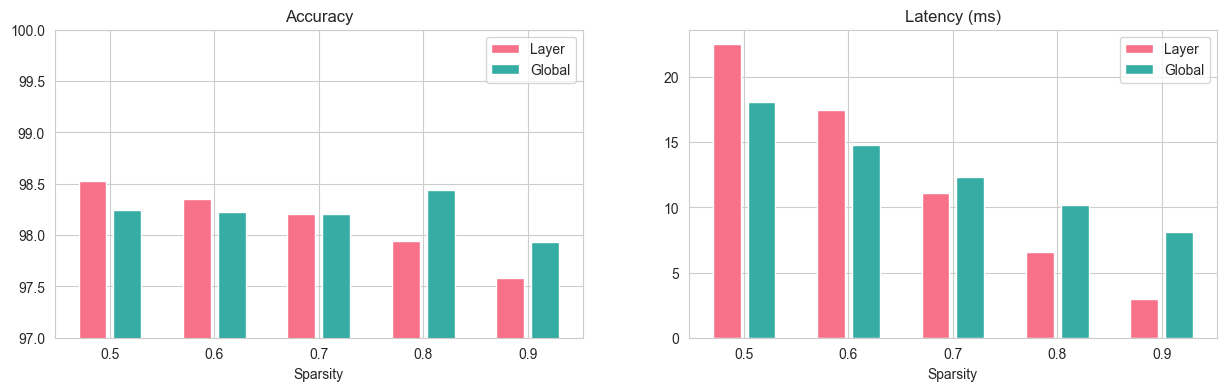

In [15]:
models = {
    "VGG16 - Layer Pruned 0.5":  "0.5",
    "VGG16 - Global Pruned 0.5": "0.5",
    "VGG16 - Layer Pruned 0.6":  "0.6",
    "VGG16 - Global Pruned 0.6": "0.6",
    "VGG16 - Layer Pruned 0.7":  "0.7",
    "VGG16 - Global Pruned 0.7": "0.7",
    "VGG16 - Layer Pruned 0.8":  "0.8",
    "VGG16 - Global Pruned 0.8": "0.8",
    "VGG16 - Layer Pruned 0.9":  "0.9",
    "VGG16 - Global Pruned 0.9": "0.9",
}

stats = get_model_stats_from_json("model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

plot_layer_vs_global(stats)

## Quantization

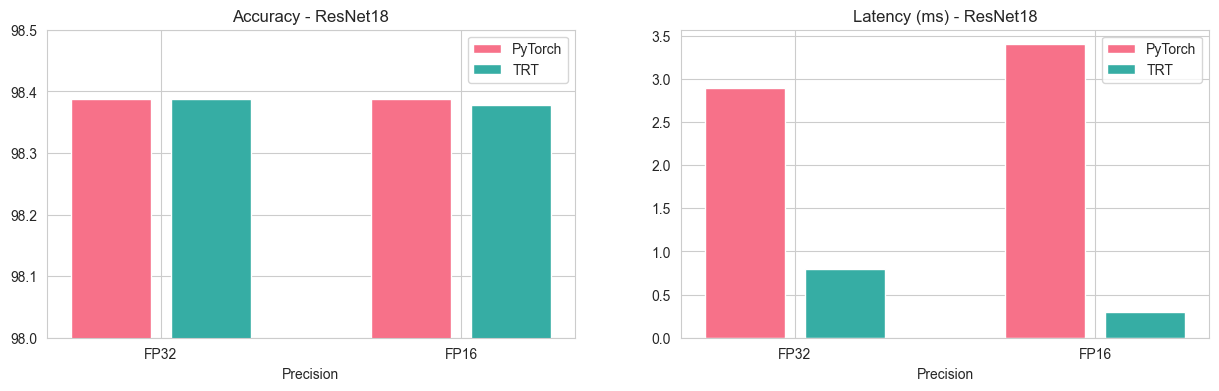

Base - TRT16: 0.009139654994896773
Latency reduction: 8.469286766104993


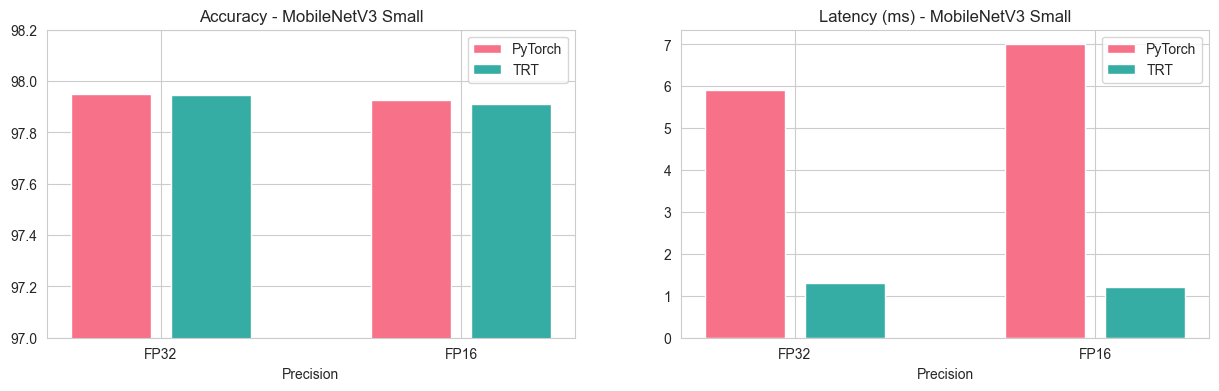

Base - TRT16: 0.036540941196236076
Latency reduction: 5.059836883463307


In [12]:
def plot_base_vs_trt(stats, accuracy_range, model):
    names   = ["FP32", "FP16"]
    accs    = [(stats[i].accuracy, stats[i+1].accuracy) for i in range(0, len(stats), 2)]
    latency = [(stats[i].latency, stats[i+1].latency) for i in range(0, len(stats), 2)]

    colors = sns.color_palette("husl", 2)

    _, ax = plt.subplots(1, 2, figsize=(15, 4))
    current_bar = 0
    for group in accs:
        ax[0].bar(current_bar, group[0], color=colors[0])
        current_bar += 1

        ax[0].bar(current_bar, group[1], color=colors[1])
        current_bar += 2

    current_bar = 0
    for group in latency:
        ax[1].bar(current_bar, round(group[0] * 1000, 1), color=colors[0])
        current_bar += 1

        ax[1].bar(current_bar, round(group[1] * 1000, 1), color=colors[1])
        current_bar += 2

    ax[0].set_ylim(accuracy_range)
    ax[0].set_xticks([0.5, 3.5])
    ax[0].set_xticklabels(names)
    ax[0].set_title(f"Accuracy - {model}")
    ax[0].set_xlabel("Precision")
    ax[0].legend(["PyTorch", "TRT"])

    ax[1].set_xticks([0.5, 3.5])
    ax[1].set_xticklabels(names)
    ax[1].set_title(f"Latency (ms) - {model}")
    ax[1].set_xlabel("Precision")
    ax[1].legend(["PyTorch", "TRT"])

    plt.show()

resnet_models = [
    "ResNet18 - FP32", "ResNet18 - TRT FP32",
    "ResNet18 - FP16", "ResNet18 - TRT FP16"
]
stats = get_model_stats_from_json("model_stats.json", resnet_models, sort=True)
plot_base_vs_trt(stats, (98, 98.5), "ResNet18")
print(f"Base - TRT16: {stats[0].accuracy - stats[3].accuracy}")
print(f"Latency reduction: {stats[0].latency / stats[3].latency}")

mobile_models = [
    "MobileNetV3 Small - FP32", "MobileNetV3 Small - TRT FP32",
    "MobileNetV3 Small - FP16", "MobileNetV3 Small - TRT FP16",
]
stats = get_model_stats_from_json("model_stats.json", mobile_models, sort=True)
plot_base_vs_trt(stats, (97, 98.2), "MobileNetV3 Small")
print(f"Base - TRT16: {stats[0].accuracy - stats[3].accuracy}")
print(f"Latency reduction: {stats[0].latency / stats[3].latency}")

## VGG Quantization

### VGG Resolution Changes for ONNX Export

In [3]:
def compute_top_mean_std(values):
    top  = max(values)
    mean = round(np.mean(values[20:]), 2)
    std  = round(np.std(values[20:]), 2)
    print(f"Top:  {top}\nMean: {mean}\nStd:  {std}")

running_accuracy_224 = np.loadtxt("Running-Data/vgg_acc_224.txt")
running_accuracy_152 = np.loadtxt("Running-Data/vgg_acc_152.txt")

print("Resolution 224")
compute_top_mean_std(running_accuracy_224) 

print("Resolution 152")
compute_top_mean_std(running_accuracy_152) 


Resolution 224
Top:  98.63
Mean: 98.31
Std:  0.46
Resolution 152
Top:  98.78
Mean: 98.41
Std:  0.22


### Main Quantization Results

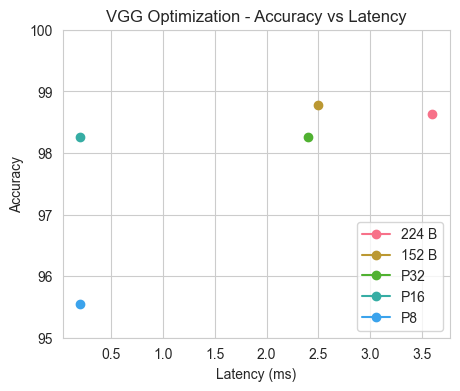

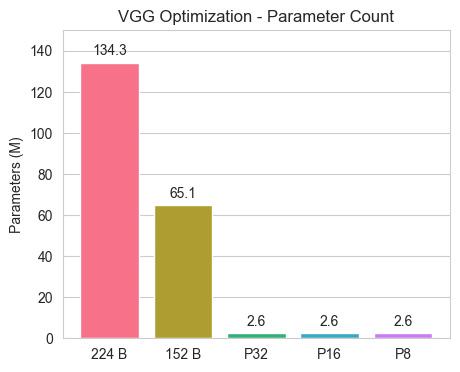

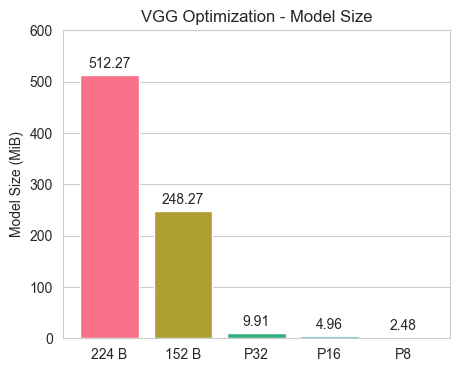

Size of 224 B: 512.2737007141113
Size of P16: 4.956932067871094
Size of P8: 2.478466033935547

Reductions 224 B => P16
	Accuracy: 0.37 (99.62%)
	Latency:  0.00 (14.93x)
	Params:   131690617.00 (51.67x)
	Size:     507.32 (103.34x)

Reductions 224 B => P8
	Accuracy: 3.08 (96.88%)
	Latency:  0.00 (15.96x)
	Params:   131690617.00 (51.67x)
	Size:     509.80 (206.69x)

Name:     224 B
Accuracy: 98.63%
Latency:  3.6 ms
Params:   134 M
MACs:     15520 M

Name:     152 B
Accuracy: 98.78%
Latency:  2.5 ms
Params:   65 M
MACs:     7076 M

Name:     P32
Accuracy: 98.26%
Latency:  2.4 ms
Params:   3 M
MACs:     284 M

Name:     P16
Accuracy: 98.26%
Latency:  0.2 ms
Params:   3 M
MACs:     284 M

Name:     P8
Accuracy: 95.55%
Latency:  0.2 ms
Params:   3 M
MACs:     284 M



In [18]:
models = {
    "VGG16 - Resolution 224 - FP32":                  "224 B",
    "VGG16 Custom 152 - FP32":                        "152 B",
    "VGG16 Custom 152 - Layer Pruned 0.8 - FP32":     "P32",
    "VGG16 Custom 152 - Layer Pruned 0.8 - TRT FP16": "P16",
    "VGG16 Custom 152 - Layer Pruned 0.8 - TRT INT8": "P8",
}

stats = get_model_stats_from_json("model_stats.json", models, sort=True)
for stat in stats:
    stat.name = models[stat.name]

# Accuracy vs Latency
accuracy_vs_latency = {
    stat.name: [(round(stat.latency * 1000, 1), stat.accuracy)] for stat in stats
}
config = PlotConfig(
    title    = "VGG Optimization - Accuracy vs Latency",
    x_label  = "Latency (ms)",
    y_label  = "Accuracy",
    y_range  = (95, 100),
    fig_size = (5, 4)
)
compare_pairwise(accuracy_vs_latency, config)

# Parameters
parameters = {
    stat.name: round(stat.params / 1e6, 1) for stat in stats
}
config = PlotConfig(
    title    = "VGG Optimization - Parameter Count",
    y_label  = "Parameters (M)",
    y_range  = (0, 150),
    x_grid   = False,
    fig_size = (5, 4)
)
compare_single_values(parameters, config, horizontal=False)

# Size
sizes = {
    stat.name: stat.params * 32 / MiB for stat in stats
}
sizes["P16"] = sizes["P32"] / 2
sizes["P8"] = sizes["P32"] / 4

for name, size in sizes.items():
    sizes[name] = round(size, 2)

config = PlotConfig(
    title    = "VGG Optimization - Model Size",
    y_label  = "Model Size (MiB)",
    y_range  = (0, 600),
    x_grid   = False,
    fig_size = (5, 4)
)
compare_single_values(sizes, config, horizontal=False)

# Reductions
parameters = {stat.name: stat.params for stat in stats}
accuracy   = {stat.name: stat.accuracy for stat in stats}
latency   = {stat.name: stat.latency for stat in stats}

size_224B  = parameters["224 B"] * 32 / MiB
size_P16   = parameters["P32"] * 16 / MiB
size_P8    = parameters["P32"] * 8 / MiB
print(f"Size of 224 B: {size_224B}")
print(f"Size of P16: {size_P16}")
print(f"Size of P8: {size_P8}")
print()

precisions = ["P16", "P8"]
for pr in precisions:
    accuracy_difference = accuracy['224 B'] - accuracy[pr]
    accuracy_maintained = accuracy[pr] / accuracy['224 B'] * 100
    latency_difference  = latency['224 B'] - latency[pr]
    latency_reduction   = latency['224 B'] / latency[pr]
    param_difference    = parameters['224 B'] - parameters[pr]
    param_reduction     = parameters['224 B'] / parameters[pr]

    size = size_P16 if pr == "P16" else size_P8
    size_difference     = size_224B - size
    size_reduction      = size_224B / size

    print(f"Reductions 224 B => {pr}")
    print(f"\tAccuracy: {accuracy_difference:.2f} ({accuracy_maintained:.2f}%)")
    print(f"\tLatency:  {latency_difference:.2f} ({latency_reduction:.2f}x)")
    print(f"\tParams:   {param_difference:.2f} ({param_reduction:.2f}x)")
    print(f"\tSize:     {size_difference:.2f} ({size_reduction:.2f}x)")
    print()

# All stats
for stat in stats:
    display_model_stats(stat)
    print()